# 1.Introduction
这是一个在MNIST数据集上训练的用于数字识别的5层顺序卷积神经网络。我选择使用keras API（Tensorflow后端）构建它，这非常直观。首先，我将准备数据（手写数字图像），然后我将专注于CNN建模和评估。
我在2h30在单个CPU（i52500k）上训练了这个CNN，达到了99.671%的准确率。对于那些拥有>=3.0 GPU功能（从GTX 650到最近的GPU）的人，您可以将tenorflow-gpu与keras一起使用。计算会快得多！！！
出于计算原因，我将步数（纪元）设置为2，如果您想达到99+%的精度，请将其设置为30。  
本笔记本分为三个主要部分：  
数据准备  
CNN建模与评估  
结果预测和提交  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

2024-01-24 11:02:33.576790: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-24 11:02:33.576829: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-24 11:02:33.578223: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-24 11:02:33.587475: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-24 11:02:34.744855: W tensorflow/compiler/tf2

# 2.Data preparation
## 2.1 Load data

In [2]:
# Load the data
train = pd.read_csv("./digit-recognizer/train.csv")
test = pd.read_csv("./digit-recognizer/test.csv")
# train = pd.read_csv("./digit-recognizer/train.csv", nrows = 2000)
# test = pd.read_csv("./digit-recognizer/test.csv", nrows = 2000)

In [3]:
# 将训练数据集中的"label"列提取出来，并赋值给变量Y_train。这表示目标变量（或标签），它包含了训练样本的正确分类。
Y_train = train["label"]
# 这一行代码从训练数据集中删除了"label"列，并将剩余的特征数据赋值给变量X_train。
X_train = train.drop(labels = ["label"],axis = 1) 
# 将名为train的数据集从内存中删除，以释放一些空间。
del train 
# 使用Seaborn库绘制了Y_train中不同类别的计数直方图。
# g = sns.countplot(X_train)
# 计算了Y_train中每个类别的样本数量，并返回一个包含每个类别及其对应样本数量的Series对象。
Y_train.value_counts()
# 10个数的频率相差不大

label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64

## 2.2 Check for null and missing values

In [4]:
# Check the data
# X_train.isnull(): 这一部分代码检查X_train中的每个元素是否为缺失值（NaN）。
# any()方法在布尔值数据框的列上执行逻辑或操作，返回一个包含每列是否存在缺失值的布尔值Series。
# describe()方法计算布尔值Series的描述性统计信息
X_train.isnull().any().describe()
# count：表示非缺失值的数量。
# unique：表示唯一值的数量。
# top：表示出现频率最高的值。
# freq：表示出现频率最高的值的频率。
# dtype：表示数据类型。

count       784
unique        1
top       False
freq        784
dtype: object

In [5]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

我检查损坏的图像（内部缺少值）。
训练和测试数据集中没有缺失值。所以我们可以安全地继续。

## 2.3 Normalization
我们执行灰度归一化以减少光照差异的影响。
此外，CNN在[0…1]数据上的转换速度比在[0…255]上的转换速度更快。

In [6]:
# Normalize the data
# 将X_train数据集中的所有像素值除以255.0。
# 由于像素值通常范围在0到255之间（对应灰度图像的颜色强度），除以255.0可以将像素值缩放到0到1的范围内。
X_train = X_train / 255.0
test = test / 255.0

## 2.4 Reshape

In [7]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
# 将X_train数据集的形状进行重塑。原本的X_train数据集是一个二维的矩阵，每一行代表一张图像，每一列代表图像的像素值。
# 通过reshape()方法，将图像数据集重塑为一个四维矩阵，其中-1表示根据数据集大小自动计算行数，
# 28表示图像的高度（28像素），28表示图像的宽度（28像素），1表示通道数（此处为灰度图像，通道数为1）。
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

训练和测试图像（28px x 28px）已存入pandas。数据帧作为784个值的一维向量。我们将所有数据重塑为28x28x1 3D矩阵。
Keras最终需要一个额外的维度来对应通道。MNIST图像是灰度缩放的，因此它只使用一个通道。对于RGB图像，有3个通道，我们会将784px向量重塑为28x28x3 3D矩阵。
## 2.5 Label encoding

In [8]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
# to_categorical是一个函数或方法（可能是自定义的），用于将标签数据进行独热编码。
# Y_train是原始的标签数据。
# num_classes指定了独热编码后向量的长度，这里设为10，代表总共有10个类别。
Y_train = to_categorical(Y_train, num_classes = 10)

标签是从0到9的10位数字。我们需要将这些标签编码为一个热向量（例如：2->[0,0,1,0,0,0,0,0,0]）。
## 2.6 Split training and valdiation set
我选择将训练集分成两部分：一小部分（10%）成为评估模型的验证集，其余部分（90%）用于训练模型。

由于我们有42 000个平衡标签的训练图像（参见2.1 Load数据），因此随机拆分训练集不会导致某些标签在验证集中过度表示。小心一些不平衡的数据集，简单的随机拆分可能会导致验证期间的评估不准确。

为了避免这种情况，您可以在train_test_split函数中使用stratify=True选项（仅适用于>=0.17 sklearn版本）。

In [9]:
# 通过设置随机种子，可以使随机过程在每次运行时都产生相同的结果，以保证实验的可重复性。
random_seed = 2
# 使用train_test_split函数将训练数据集X_train和标签数据集Y_train拆分成训练集X_train、验证集X_val、训练集标签Y_train和验证集标签Y_val。
# X_train和Y_train是原始的训练数据集和标签数据集。
# test_size = 0.1表示将10%的数据分配给验证集，即验证集占总训练数据的比例为10%。
# random_state=random_seed表示使用之前设置的随机种子2来控制数据的拆分过程，确保每次运行时都得到相同的拆分结果。
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

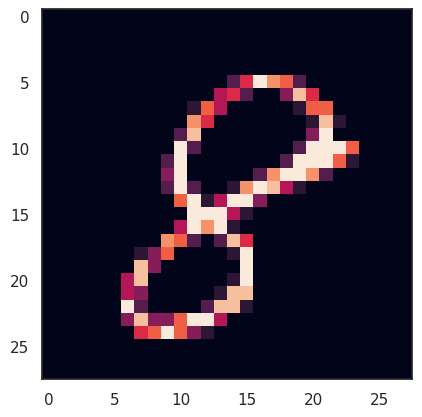

In [10]:
# 我们可以通过视觉化图像和查看标签来更好地理解其中一个例子。
# X_train是训练集数据，其中索引为0的样本被选中进行可视化。
# X_train[0]表示训练集中的第一个样本。
# [:,:,0]表示选择第一个样本的所有行和列，并且选择通道为0的部分。
# 这里的0表示灰度图像的通道索引，因为之前的操作将图像数据重塑为四维张量，其中最后一个维度是通道维度。
g = plt.imshow(X_train[0][:,:,0])

# 3.CNN
## 3.1 Define the model
我使用了Keras Sequential API，您只需一次添加一层，从输入开始。

第一个是卷积（Conv2D）层。它就像一组可学习的过滤器。我选择为两个第一个卷积2D层设置32个过滤器，为最后两个设置64个过滤器。每个过滤器使用内核过滤器转换图像的一部分（由内核大小定义）。内核过滤器矩阵应用于整个图像。过滤器可以看作是图像的转换。

CNN可以从这些转换后的图像（特征图）中分离出在任何地方都有用的特征。

CNN中的第二个重要层是池化（MaxPool2D）层。该层简单地充当下采样过滤器。它查看2个相邻像素并选择最大值。这些用于降低计算成本，并在某种程度上减少过拟合。我们必须选择池化大小（即每次池化的区域大小）池化维度越高，下采样就越重要。

结合卷积层和池化层，CNN能够结合局部特征并学习图像的更多全局特征。

Dropout是一种正则化方法，对于每个训练样本，层中的一部分节点被随机忽略（将它们的重量设置为零）。这会随机丢弃网络的比例，并迫使网络以分布式方式学习特征。这种技术还提高了泛化并减少了过拟合。

'relu'是整流器（激活函数max（0， x）。整流器激活函数用于向网络添加非线性。

扁平化层用于将最终的特征图转换为一个单一的一维向量。需要这个扁平化步骤，以便您可以在一些卷积/最大池层之后使用完全连接的层。它结合了以前卷积层的所有发现的局部特征。

最后，我在两个全连接（密集）层中使用了特征，这只是人工神经网络（ANN）分类器。在最后一层（密集（10，激活="softmax"））中，网络输出每个类的概率分布。

In [11]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
# 创建一个Sequential模型对象，用于构建CNN模型。
model = Sequential()
# 添加第一个卷积层。这个卷积层有32个滤波器（filters），每个滤波器的大小为5x5。
# padding参数设置为'Same'，表示使用零填充来保持输入和输出的大小相同。激活函数使用ReLU。
# input_shape参数指定输入的形状为(28, 28, 1)，即图像的高度为28像素，宽度为28像素，通道数为1（灰度图像）。
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
# 添加第二个卷积层，与前面的卷积层类似。
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
# 添加最大池化层。这个池化层的池化窗口大小为2x2，通过降低特征图的空间尺寸来减少参数数量。
model.add(MaxPool2D(pool_size=(2,2)))
# 添加一个dropout层，以减少过拟合。这里的0.25表示丢弃输入单元的比例为25%。
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

# 展平层（将多维输入展平为一维）
model.add(Flatten())
# 一个全连接层（256个神经元，使用ReLU激活函数）
model.add(Dense(256, activation = "relu"))
# 一个dropout层（丢弃输入单元的比例为50%）
model.add(Dropout(0.5))
# 一个全连接层（10个神经元，使用softmax激活函数）
model.add(Dense(10, activation = "softmax"))

## 3.2 Set the optimizer and annealer
一旦我们的层被添加到模型中，我们需要设置一个分数函数、一个损失函数和一个优化算法。

我们定义损失函数来衡量我们的模型在具有已知标签的图像上的表现有多差。它是观察标签和预测标签之间的错误率。我们使用一种特定的形式进行分类（>2类），称为“categorical_crossentropy”。

最重要的功能是优化器。该函数将迭代改进参数（过滤内核值、权重和神经元的偏差……）以最大限度地减少损失。

我选择了RMSprop（具有默认值），它是一个非常有效的优化器。RMSProp更新以非常简单的方式调整Adagrad方法，试图降低其激进的、单调递减的学习率。我们也可以使用随机梯度下降（'sgd'）优化器，但它比RMSprop慢。

使用的度量函数“准确度”是评估我们模型的性能，这个度量函数与损失函数类似，只是训练模型时不使用度量评估的结果（仅用于评估）。

为了使优化器更快地收敛并最接近损失函数的全局最小值，我使用了学习率（LR）的退火方法。学习率退火（learning rate annealing）是在训练过程中动态地调整学习率的一种策略。学习率是深度学习中一个重要的超参数，它控制着参数更新的步长，对模型的性能和收敛速度有着重要影响。
学习率退火的目的是在训练的早期使用较大的学习率，以便更快地接近全局最优解。随着训练的进行，学习率逐渐减小，以提高模型的稳定性和收敛性。这种策略可以帮助模型跳出局部最优解并更好地探索参数空间。

LR是优化器走过“损失景观”的步骤。LR越高，步长越大，收敛速度越快。然而，高LR的采样很差，优化器可能会陷入局部最小值。
最好在训练期间降低学习率，以有效地达到损失函数的全局最小值。
为了保持高LR的快速计算时间的优势，我根据需要（当精度没有提高时）每X步（epochs）动态降低LR。
使用Keras.callback中的Reduce eLROnPlateau函数，如果3个epochs后精度没有提高，我选择将LR减少一半。

In [12]:
from tensorflow.keras.optimizers import legacy
# 定义优化器
# optimizer参数接受了legacy.RMSprop实例，这个实例使用了指定的学习率（lr）、衰减率（rho）和epsilon值。
optimizer = legacy.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08)
# 编译模型
# 将优化器、损失函数和评估指标配置到模型中。这里使用了"categorical_crossentropy"作为损失函数，适用于多类别分类问题。
# metrics参数指定了评估指标，这里选择了准确率（accuracy）作为评估模型性能的指标。
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/rmsprop.py:144: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [13]:
# 定义了一个学习率退火（learning rate annealing）的方法，并设置了一些参数
# monitor='val_acc'：监控的指标。这里使用了验证集的准确率作为监控指标。
# patience=3：如果在连续3个epoch内没有看到验证指标有改善，则减小学习率。
# verbose=1：输出学习率调整的信息。
# factor=0.5：学习率减小的因子。当学习率调整时，将当前学习率乘以该因子。
# min_lr=0.00001：学习率的下限。学习率将不会减小到小于这个值。
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
# 将epochs转换为30以获得0.9967精度
# epochs表示训练的轮数，这里设置为1。
epochs = 1
# 表示每个批次训练的样本数，这里设置为86。
batch_size = 86

## 3.3 Data augmentation
为了避免过度拟合问题，我们需要人为地扩展我们的手写数字数据集。我们可以使您现有的数据集更大。这个想法是通过小的转换来改变训练数据，以重现当有人写入数字时发生的变化。  
例如，数字不居中比例不一样（一些用大/小数字书写的人）图像旋转…  
以改变数组表示方式同时保持标签不变的方式改变训练数据的方法称为数据增强技术。人们使用的一些流行的增强是灰度、水平翻转、垂直翻转、随机裁剪、颜色抖动、平移、旋转等等。  
通过对我们的训练数据应用其中的几个转换，我们可以轻松地将训练示例的数量增加一倍或三倍，并创建一个非常健壮的模型。

改进很重要：  
在没有数据增强的情况下，我获得了98.114%的准确率  
通过数据增强，我达到了99.67%的准确率

In [14]:
# 在没有数据增强的情况下，我获得了98.114%的准确率
# 使用了model.fit函数来训练模型，并传入了训练集数据X_train和标签Y_train，批次大小batch_size和训练轮数epochs。
# 同时，你还提供了验证集数据X_val和标签Y_val作为验证数据，以便在训练过程中监控模型的性能。
# verbose参数用于控制训练过程中的输出信息的详细程度。
# verbose = 0：静默模式，不输出任何信息。
# verbose = 1：默认模式，显示进度条和每个epoch的训练结果。
# verbose = 2：安静模式，只显示每个epoch的训练结果。
history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
         validation_data = (X_val, Y_val), verbose = 2)


440/440 - 29s - loss: 0.2442 - accuracy: 0.9229 - val_loss: 0.0822 - val_accuracy: 0.9721 - 29s/epoch - 66ms/step


In [15]:
# 具有数据增强以防止过拟合（精度0.99286）
# 创建了一个ImageDataGenerator对象，并通过设置不同的参数来定义数据增强的方式。
datagen = ImageDataGenerator(
        # 布尔值，表示是否在整个数据集上将输入特征减去均值。
        featurewise_center=False,  # set input mean to 0 over the dataset
        # 布尔值，表示是否在每个样本上将输入特征减去均值。
        samplewise_center=False,  # set each sample mean to 0
        # 布尔值，表示是否在整个数据集上将输入特征除以标准差。
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        # 布尔值，表示是否在每个样本上将输入特征除以标准差。
        samplewise_std_normalization=False,  # divide each input by its std
        # 布尔值，表示是否应用ZCA白化。
        zca_whitening=False,  # apply ZCA whitening
        # 整数值，表示随机旋转图像的角度范围（0到180度）。
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        # 浮点数或形如[lower, upper]的列表/元组，表示随机缩放图像的范围。
        zoom_range = 0.1, # Randomly zoom image
        # 浮点数，表示随机水平平移图像的范围（相对于总宽度的比例）。
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        # 浮点数，表示随机垂直平移图像的范围（相对于总高度的比例）。
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        # 布尔值，表示是否随机水平翻转图像。
        horizontal_flip=False,  # randomly flip images
        # 布尔值，表示是否随机垂直翻转图像。
        vertical_flip=False)  # randomly flip images

# 将数据增强器应用到训练集数据X_train上，以便在每个epoch期间生成随机变换后的图像。
datagen.fit(X_train)

In [16]:
# Fit the model
# datagen.flow()：将数据增强器应用到训练集数据X_train和标签Y_train上，并生成批次大小为batch_size的扩充样本。
# 这个生成器会在每个epoch期间生成随机变换后的样本，并作为模型的输入。

# epochs：表示训练的轮数。
# validation_data=(X_val, Y_val)：指定验证集的数据X_val和标签Y_val，用于在训练过程中评估模型的性能。
# verbose=2：以安静模式进行训练，只显示每个epoch的训练结果。

# steps_per_epoch=X_train.shape[0] // batch_size：表示每个epoch中的步数，即每个epoch中要处理的批次数。
# 这里使用整除操作符//来确保每个epoch中都能遍历完整个训练集。

# callbacks=[]：通过回调函数列表指定了一个回调函数learning_rate_reduction，用于在训练过程中根据需要调整学习率。
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

/tmp/ipykernel_2840818/2276340005.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),


439/439 - 28s - loss: 0.1845 - accuracy: 0.9440 - val_loss: 0.0533 - val_accuracy: 0.9836 - lr: 0.0010 - 28s/epoch - 63ms/step


# 4.Evaluate the model
## 4.1 Training and validation curves

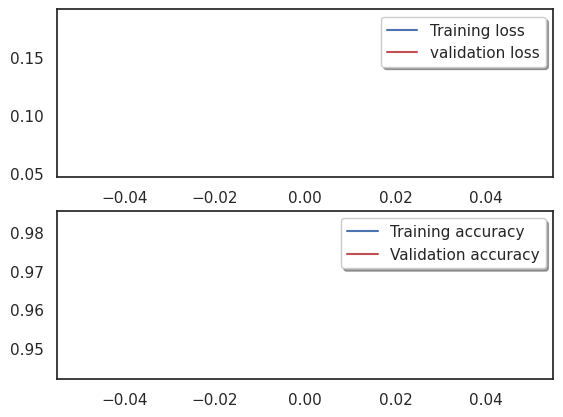

In [17]:
# 绘制用于训练和验证的损失和准确度曲线
# 创建了一个包含两个子图的图形对象，其中 2,1 表示两行一列的布局，即两个子图分别位于上下两行。
fig, ax = plt.subplots(2,1)
# 绘制了训练集的损失曲线，history.history['loss'] 是训练过程中记录的损失值的列表。
# color='b' 指定线条颜色为蓝色，label="Training loss" 设置了图例标签为 "Training loss"。
ax[0].plot(history.history['loss'], color='b', label="Training loss")
# 绘制了验证集的损失曲线，color='r' 表示线条颜色为红色，label="validation loss" 设置了图例标签为 "Validation loss"。
ax[0].plot(history.history['val_loss'], color='r', label="validation loss")
# 添加了一个图例，loc='best' 表示图例位置自动选择最佳位置，shadow=True 表示显示阴影效果，以增强可读性。
legend = ax[0].legend(loc='best', shadow=True)
 
ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

下面的代码用于绘制训练和验证的损失和准确性曲线。因为，我在这个笔记本上设置了epochs=2。我将向您展示我从使用30个epochs（2h30）构建的模型中获得的训练和验证曲线。

经过2个时期后，该模型在验证数据集上的准确率接近99%（98.7+%）。在训练过程中，验证准确率几乎每次都大于训练准确率。这意味着我们的模型不会过度拟合训练集。  
我们的模型训练有素！！！
## 4.2 Confusion matrix
混淆矩阵可以非常有帮助地看到您的模型缺点。  
我绘制了验证结果的混淆矩阵。

132/132 [==============================] - 1s 5ms/step


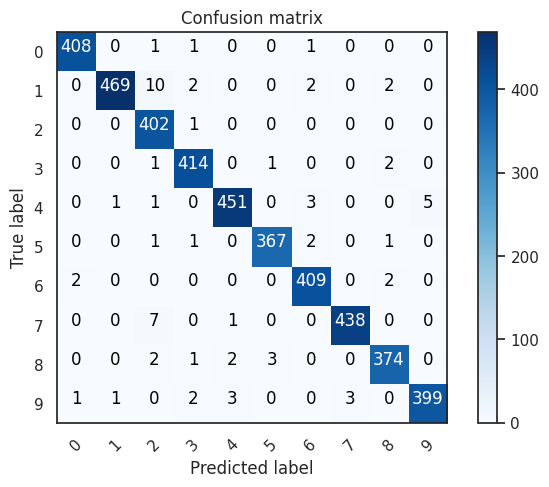

In [18]:
# 这段代码用于绘制混淆矩阵（Confusion Matrix）的图形，可以通过设置“规范化=True”来应用规范化。
# cm：混淆矩阵的数据。
# classes：分类的类别标签。
# normalize：是否对混淆矩阵进行归一化，默认为 False。
# title：图形的标题，默认为 "Confusion matrix"。
# cmap：使用的颜色图谱，默认为 plt.cm.Blues。
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    # 使用 plt.imshow 来绘制混淆矩阵，interpolation='nearest' 指定了插值方法，cmap=cmap 指定了颜色图谱。
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # 设置图形的标题
    plt.title(title)
    # 添加颜色条
    plt.colorbar()
    # 设置坐标轴刻度的标签
    tick_marks = np.arange(len(classes))
    # 设置坐标轴刻度的位置
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # 如果 normalize 参数为 True，则将混淆矩阵进行归一化处理，使得每一行的和为 1。
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    # 通过计算 cm 的最大值的一半来确定文本颜色的阈值。
    thresh = cm.max() / 2.
    # 使用嵌套的循环遍历混淆矩阵的每个元素，并使用 plt.text 在图形中的相应位置上显示混淆矩阵的值。
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        # 如果值大于阈值，则使用白色显示，否则使用黑色显示。
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    # 调整图形布局
    plt.tight_layout()
    # 设置坐标轴的标签。
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# 使用训练好的模型 model 对验证数据集 X_val 进行预测，得到预测结果 Y_pred。
Y_pred = model.predict(X_val)
# 通过 np.argmax 将预测结果和验证集的真实标签转换为独热编码的形式，分别得到 Y_pred_classes 和 Y_true。 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(Y_val,axis = 1) 
# 计算混淆矩阵，将真实标签 Y_true 和预测标签 Y_pred_classes 作为输入。
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# 传入混淆矩阵和类别标签参数，绘制混淆矩阵的图形。
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

在这里，我们可以看到我们的CNN在所有数字上都表现得非常好，考虑到验证集的大小（4 200张图像），几乎没有错误。  
然而，我们的CNN似乎在4位数字上有一些小问题，他们被错误地归类为9。有时候当曲线平滑时，很难捕捉到4和9之间的区别。  
## 4.3 handle results
让我们调查错误。  
我想看到最重要的错误。为此，我需要得到结果中真实值和预测值的概率之间的差异。

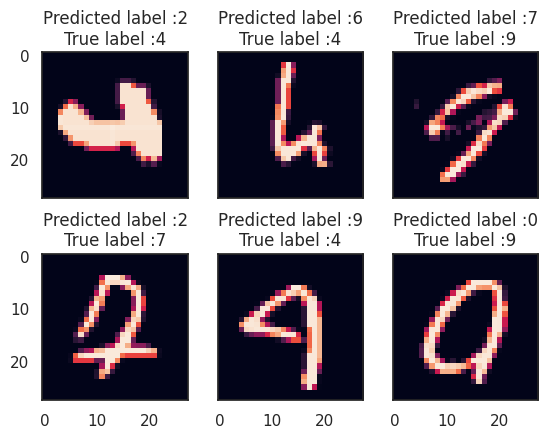

In [19]:
# 这段代码用于显示分类模型中的一些错误结果。

# 通过计算预测标签和真实标签之间的差异，确定哪些样本被错误分类，将结果存储在名为 errors 的布尔数组中。
errors = (Y_pred_classes - Y_true != 0)
Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

# 定义了一个名为 display_errors 的函数，用于显示6个错误分类的样本图像、预测标签和真实标签。
def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    # 函数通过创建一个2行3列的子图布局，并在每个子图中显示一个错误分类的图像。
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            # 图像被重新调整为28x28的形状
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            # 在子图标题中显示预测标签和真实标签
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# 通过计算错误预测的数字的概率分布，将结果存储在 Y_pred_errors_prob 中。
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# 计算错误分类样本中真实标签的预测概率，并将结果存储在 true_prob_errors 中。
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# 计算预测标签和真实标签之间概率差异的大小，并将结果存储在 delta_pred_true_errors 中。
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# 对概率差异进行排序，并将结果存储在 sorted_dela_errors 中。
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# 选择概率差异最大的前6个错误分类，并将结果存储在 most_important_errors 中。
most_important_errors = sorted_dela_errors[-6:]

# 传入最重要的错误分类索引、错误分类的图像数据、预测标签和真实标签，以显示最重要的6个错误分类的样本图像和标签。
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

# 最重要的错误也是最有趣的。
# 对于这六个案例，模型并不荒谬。其中一些错误也可能是人类犯的，尤其是对于一个非常接近4的9。最后9也很误导人，对我来说似乎是0。

In [20]:
# 用于对测试数据进行预测，并将预测结果保存在一个名为 results 的变量中。

# 通过调用模型的 predict 方法对测试数据 test 进行预测，得到预测结果 results。预测结果是一个概率分布，表示每个类别的预测概率。
results = model.predict(test)
# 通过使用 np.argmax 函数选择概率分布中概率最大的索引，作为最终的预测结果。这相当于选择概率最大的类别作为预测的标签。
results = np.argmax(results,axis = 1)
# 将预测结果转换为一个名为 "Label" 的 pd.Series 对象，并将其保存在 results 变量中。
results = pd.Series(results,name="Label")

875/875 [==============================] - 4s 5ms/step


In [21]:
# 创建一个包含序列号的 pd.Series 对象，范围从1到28000，名称为 "ImageId"。
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
# 调用 to_csv 方法，将这个数据框保存为一个名为 "cnn_mnist_datagen.csv" 的CSV文件。
# index=False 参数表示不将行索引写入CSV文件，只保留列数据。
submission.to_csv("cnn_mnist_datagen.csv",index=False)